In [1]:
# 토픽 모델링은 다양한 문서 집합에 내재한 토픽, 즉 주제를 파악할 때 쓰는 방법이다.
# 예측보다는 내용의 분석 자체를 목적으로 하는 기법
# LDA
# 단어의 집합으로 문서에 담긴 주제를 표현하면 더 구체적이고 명확하게 의미를 보여줄 수 있다는 점

# 문서에 따른 토픽의 확률분포를 추정하는 것이 토픽 모델링의 첫째 목적이 된다.
# 디리클레 분포는 연속 확률분포의 하나이며, k차원의 실수 벡터에서 각 벡터 값이 양수이고 모든 값을 더하면 1이 되는 경우에 대해 확률값이 정의
# 토픽 모델링의 둘째 목표는 각 토픽의 단어분포를 알아내는 것이다. 토픽은 그 토픽을 구성하는 단어들의 비중으로 표현된다.

# 무엇이 적절한 값인지 판단하려면 성능에 대한 척도가 필요한데, 주로 사용하는 것으로 혼란도와 토픽 응집도가 있다.
# 혼란도(Perplexity) : 보통은 특정한 확률 모형이 실제로 관측되는 값을 얼마나 유사하게 예측해내는지를 평가할 때 사용, 값이 작으면 좋음
# 토픽 응집도(coherence) : 각 토픽에서 상위 비중을 차지하는 단어들이 의미적으로 유사한지를 나타내는 척도. 값이 크면 좋음
# 토픽 모형의 성능을 평가할 때 수치보다 사람이 보기에 자연스러운 것이 더 중요하다.

In [2]:
# 사이킷런을 이용한 토픽 모델링
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space', 'comp.sys.ibm.pc.hardware',
             'sci.crypt']

# 학습 데이터셋을 가져옴
newsgroups_train = fetch_20newsgroups(subset='train', categories = categories)

print('#Train set size:', len(newsgroups_train.data))
print('#Selected categories:', newsgroups_train.target_names)

#Train set size: 3219
#Selected categories: ['alt.atheism', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.crypt', 'sci.space', 'talk.religion.misc']


In [3]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(token_pattern = "[\w']{3,}", stop_words = 'english',
                    max_features=2000, min_df = 5, max_df=0.5)
review_cv = cv.fit_transform(newsgroups_train.data)

In [4]:
# LDA 토픽 모델링 실행
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
np.set_printoptions(precision=3)

lda = LatentDirichletAllocation(n_components=10, # 추출할 topic의 수
                               max_iter=5,
                               topic_word_prior = 0.1, doc_topic_prior=1.0,
                               learning_method='online',
                               n_jobs = -1, # 사용 processor 수
                               random_state=0)

review_topics = lda.fit_transform(review_cv)
print('#shape of review_topics:',review_topics.shape)
print('#Sample of review_topics:',review_topics[0])

gross_topic_weighs = np.mean(review_topics, axis=0)
print('#Sum of topic weighs of documents:',gross_topic_weighs)

print('#shape of topic word distribution:',lda.components_.shape)

#shape of review_topics: (3219, 10)
#Sample of review_topics: [0.902 0.007 0.028 0.008 0.007 0.008 0.008 0.007 0.007 0.017]
#Sum of topic weighs of documents: [0.087 0.083 0.086 0.114 0.116 0.131 0.092 0.072 0.071 0.148]
#shape of topic word distribution: (10, 2000)


In [5]:
# 비중 높은 단어 10~20개 
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print('Topic #%d:' % topic_idx, end='')
        print(
            ','.join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        )
        
        
        #위 slicing에서 맨 뒤 -1은 역순의 의미, 역순으로 했을 때 처으무터
        #n_top_words까지
    print()
print_top_words(lda, cv.get_feature_names_out(), 10)    

Topic #0:com,morality,article,sgi,keith,sandvik,objective,think,moral,don't
Topic #1:image,graphics,file,files,ftp,available,software,data,use,pub
Topic #2:space,nasa,access,launch,earth,orbit,shuttle,digex,lunar,satellite
Topic #3:article,just,com,don't,like,nntp,host,posting,i'm,university
Topic #4:key,clipper,chip,encryption,com,government,law,keys,use,escrow
Topic #5:scsi,com,bit,ibm,thanks,know,bus,university,posting,nntp
Topic #6:gov,nasa,host,nntp,university,posting,distribution,___,center,world
Topic #7:drive,com,disk,hard,controller,drives,dos,tape,floppy,problem
Topic #8:key,public,faq,message,mail,pgp,group,des,uni,sci
Topic #9:god,people,don't,jesus,just,believe,does,say,think,know



n_components:6, perplexity:1061.456
n_components:7, perplexity:1063.705
n_components:8, perplexity:1010.231
n_components:9, perplexity:1022.315
n_components:10, perplexity:1026.688
n_components:11, perplexity:1038.270
n_components:12, perplexity:1032.219
n_components:13, perplexity:1036.676
n_components:14, perplexity:1038.562
n_components:15, perplexity:1044.049


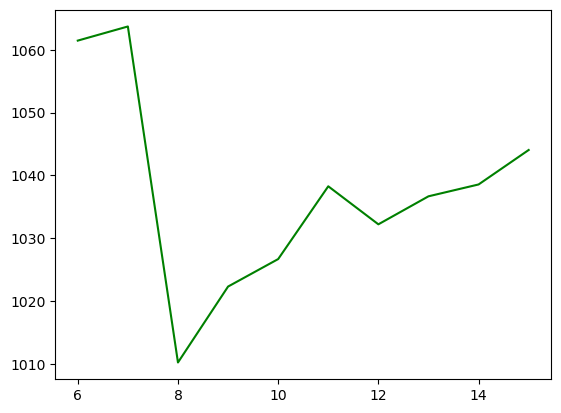

n_components with minimum perplexity: 8


In [6]:
# 최적의 토픽 수 선택하기
import matplotlib.pyplot as plt
%matplotlib inline
def show_perplexity(cv, start=10, end=30, max_iter=5, topic_word_prior=0.1,
                   doc_topic_prior = 1.0):
    iter_num = []
    per_value = []
    
    for i in range(start, end + 1):
        lda = LatentDirichletAllocation(n_components=i, max_iter=max_iter,
                                       topic_word_prior = topic_word_prior,
                                       doc_topic_prior = doc_topic_prior,
                                       learning_method = 'batch', n_jobs=-1,
                                       random_state=7)
        lda.fit(cv)
        iter_num.append(i)
        pv = lda.perplexity(cv)
        per_value.append(pv)
        print(f'n_components:{i}, perplexity:{pv:0.3f}')
        
    plt.plot(iter_num, per_value, 'g-')
    plt.show()
    return start + per_value.index(min(per_value))

print('n_components with minimum perplexity:',
     show_perplexity(review_cv, start=6, end=15))
    

In [7]:
lda = LatentDirichletAllocation(n_components=8, #추출할 topic의 수를 지정
                               max_iter=20,
                               topic_word_prior = 0.1,
                               doc_topic_prior=1.0,
                               learning_method = 'batch',
                               n_jobs=-1,
                               random_state=7)

review_topics = lda.fit_transform(review_cv)

print_top_words(lda, cv.get_feature_names_out(), 10)

Topic #0:image,graphics,file,available,mail,ftp,data,information,files,software
Topic #1:posting,nntp,host,com,university,gov,article,distribution,reply,___
Topic #2:com,keith,morality,article,think,caltech,sgi,don't,objective,moral
Topic #3:com,jesus,article,know,just,don't,god,i'm,good,people
Topic #4:people,god,does,don't,think,say,believe,just,way,like
Topic #5:drive,scsi,card,com,disk,ide,controller,hard,bus,use
Topic #6:space,nasa,access,launch,moon,year,earth,digex,orbit,shuttle
Topic #7:key,encryption,clipper,chip,com,government,keys,use,security,public



In [8]:
# Gensim을 이용한 토픽 모델링
# 토픽 모델링을 비롯해 의미적인 자연어 처리를 위한 다양한 라이브러리를 제공한다.
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

cachedStopWords = stopwords.words('english')

RegTok = RegexpTokenizer("[\w']{3,}") # 정규표현식으로 토크나이저를 정의
english_stops = set(stopwords.words('english'))  # 영어 불용어를 가져옴

def tokenizer(text):
    tokens = RegTok.tokenize(text.lower())
    # stopwords 제외
    words = [word for word in tokens if (word not in english_stops) and len(word) > 2]
    return words

texts = [tokenizer(news) for news in newsgroups_train.data]

In [9]:
from gensim.corpora.dictionary import Dictionary

# 토큰화 결과로부터 dictionary 생성
dictionary = Dictionary(texts)
print('#Number of initial unique words in documents:', len(dictionary))

# 문서 빈도수가 너무 적거나 높은 단어를 필터링하고 특성을 단어의 빈도 순으로 선택
dictionary.filter_extremes(keep_n=2000, no_below=5, no_above=0.5) # 인수, min_df, max_df
print('#Number of unique words after removing rare and common words:', len(dictionary))

# 카운트 벡터로 변환
corpus = [dictionary.doc2bow(text) for text in texts]
print('#Number of unique tokens: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

#Number of initial unique words in documents: 46466
#Number of unique words after removing rare and common words: 2000
#Number of unique tokens: 2000
#Number of documents: 3219


In [10]:
from gensim.models import LdaModel

num_topics = 10 # 토픽의 수
passes = 5 # max_iter
%time model = LdaModel(corpus=corpus, id2word=dictionary,\
                      passes=passes, num_topics = num_topics, \
                      random_state=7) # corpus 인수 , 소요된 시간 출력

CPU times: total: 8.16 s
Wall time: 15.8 s


In [11]:
model.print_topics(num_words=10) # 각 토픽의 상위 비중 단어//// num_topics 매개변수로 보고 싶은 토픽의 수

[(0,
  '0.023*"com" + 0.018*"keith" + 0.016*"caltech" + 0.013*"sgi" + 0.013*"nntp" + 0.013*"posting" + 0.013*"host" + 0.012*"would" + 0.012*"system" + 0.011*"livesey"'),
 (1,
  '0.020*"morality" + 0.018*"objective" + 0.015*"one" + 0.015*"say" + 0.014*"uiuc" + 0.012*"frank" + 0.012*"values" + 0.010*"faq" + 0.010*"article" + 0.008*"cso"'),
 (2,
  '0.026*"com" + 0.025*"access" + 0.025*"posting" + 0.023*"host" + 0.023*"nntp" + 0.017*"digex" + 0.015*"article" + 0.013*"cwru" + 0.013*"___" + 0.013*"net"'),
 (3,
  '0.021*"university" + 0.017*"posting" + 0.015*"host" + 0.015*"nntp" + 0.013*"article" + 0.010*"com" + 0.009*"know" + 0.009*"i\'m" + 0.009*"would" + 0.009*"thanks"'),
 (4,
  '0.032*"com" + 0.015*"would" + 0.011*"article" + 0.010*"one" + 0.010*"get" + 0.009*"people" + 0.009*"ibm" + 0.008*"government" + 0.007*"good" + 0.007*"i\'m"'),
 (5,
  '0.025*"key" + 0.017*"encryption" + 0.014*"clipper" + 0.014*"chip" + 0.009*"keys" + 0.009*"use" + 0.008*"security" + 0.008*"government" + 0.008*"pub

In [12]:
print('#topic distribution of the first document:', model.get_document_topics(corpus[0])) #토픽 분포, 사이킷런의 결과와 비슷

#topic distribution of the first document: [(0, 0.7257719), (8, 0.26994798)]


In [13]:
# gensim 시각화
# pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# LDA 모형을 pyLDAvis 객체에 전달
lda_viz = gensimvis.prepare(model, corpus, dictionary)
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.137200  0.040249       1        1  22.655430
5      0.065990  0.123619       2        1  14.522811
9      0.072133  0.092872       3        1  12.987431
7      0.138320  0.043608       4        1  11.020430
4     -0.021828  0.007494       5        1   9.298366
6      0.072783 -0.094709       6        1   9.118880
3      0.027375 -0.054949       7        1   8.494199
0     -0.040788 -0.129974       8        1   4.524040
2      0.005360 -0.091972       9        1   4.051827
1     -0.182145  0.063762      10        1   3.326586, topic_info=            Term         Freq        Total Category  logprob  loglift
538        space  1487.000000  1487.000000  Default  30.0000  30.0000
20           com  3752.000000  3752.000000  Default  29.0000  29.0000
834          key  1316.000000  1316.000000  Default  28.0000  28.0000
1551        scsi   741.000000   741.000000  Default  27.0000  27.0000
70       posting  1723.000000  1723.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
65        people    64.444149  1672.570915  Topic10  -5.1558   0.1469
789          sci    53.262774   309.473888  Topic10  -5.3463   1.6436
602   university    56.862488  1487.219649  Topic10  -5.2810   0.1392
294         time    55.766934  1187.715484  Topic10  -5.3004   0.3446
315       better    54.192057   564.543605  Topic10  -5.3291   1.0597

[592 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1359      1  0.006274      128
1359      2  0.069013      128
1359      3  0.037643      128
1359      4  0.878342      128
153       1  0.057463     1993
...     ...       ...      ...
343       8  0.022394    years
343       9  0.005599    years
343      10  0.121303    years
704       3  0.991487      zoo
705       3  0.984036  zoology

[2804 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 10, 8, 5, 7, 4, 1, 3, 2])

In [14]:
# 혼란도와 토픽 응집도를 이용한 최적값 선택
from gensim.models import CoherenceModel # 토픽 응집도 계산

cm = CoherenceModel(model=model, corpus = corpus, coherence = 'u_mass')
coherence = cm.get_coherence()
print(coherence)

-1.7493528544065975


num_topics:6, perplexity:-7.035, coherence:-1.701
num_topics:7, perplexity:-7.023, coherence:-1.735
num_topics:8, perplexity:-7.023, coherence:-1.547
num_topics:9, perplexity:-7.007, coherence:-1.891
num_topics:10, perplexity:-6.996, coherence:-1.888
num_topics:11, perplexity:-7.027, coherence:-2.164
num_topics:12, perplexity:-7.019, coherence:-2.018
num_topics:13, perplexity:-7.025, coherence:-2.255
num_topics:14, perplexity:-7.020, coherence:-2.082
num_topics:15, perplexity:-7.019, coherence:-2.521


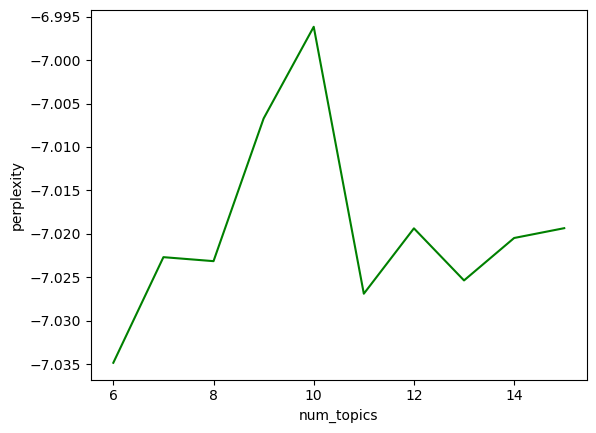

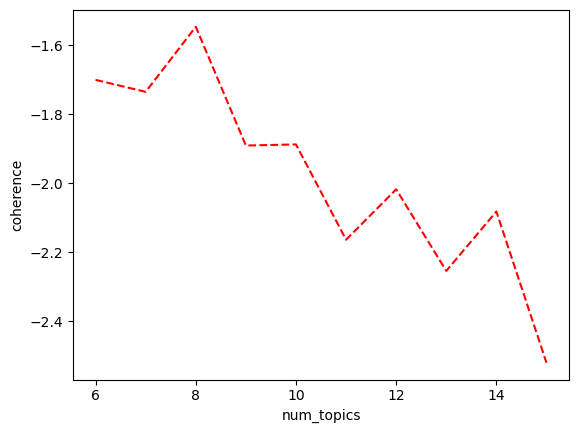

In [15]:
def show_coherence(corpus, dictionary, start=6, end=15):
    iter_num=[]
    per_value=[]
    coh_value=[]
    
    for i in range(start, end + 1):
        model = LdaModel(corpus=corpus, id2word = dictionary,
                        chunksize=1000, num_topics=i,
                        random_state=7)
        iter_num.append(i)
        pv = model.log_perplexity(corpus)
        per_value.append(pv)
        
        cm = CoherenceModel(model=model, corpus = corpus, coherence = 'u_mass')
        cv = cm.get_coherence()
        coh_value.append(cv)
        print(f'num_topics:{i}, perplexity:{pv:0.3f}, coherence:{cv:0.3f}')
        
    plt.plot(iter_num, per_value, 'g-')
    plt.xlabel('num_topics')
    plt.ylabel('perplexity')
    plt.show()
    
    plt.plot(iter_num, coh_value, 'r--')
    plt.xlabel('num_topics')
    plt.ylabel('coherence')
    plt.show()
show_coherence(corpus, dictionary,start=6, end=15)    

In [16]:
# 토픽 트렌드로 시간에 따른 주제의 변화 알아내기
import pandas as pd

df = pd.read_csv('petition_sampled.csv')
df.iloc[[2]]

,article_id,start,end,answered,votes,category,title,content
2,136,2017-08-20,2017-11-18,0,4,육아/교육,고등학교 교육 내용 수준을 낮춰주시고 실용적인 내용을 담아주세요!,저는 광주에 사는 중3 학생입니다. 고등학교 가기 직전의 학년이라 어느 때보다 고등...


In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Okt
twit = Okt()

def tokenizer(doc):
    return [token for token in twit.nouns(doc) if len(token) > 1]
vec = CountVectorizer(tokenizer=tokenizer, # 우선은 명사만 사용
                     max_df=0.5, min_df=5,
                     max_features = 1000) # 적당한 대상 단어 수를 선택

pet_cv  = vec.fit_transform(df.content)
print(pet_cv.shape)

C:\Users\Leedonghoon\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(18077, 1000)


In [18]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=15, \
                               n_jobs=-1, \
                               random_state=0)

%time pet_topics = lda.fit_transform(pet_cv)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print('Topic #%d:' % topic_idx, end='')
        print(','.join([feature_names[i]
                       for i in topic.argsort()[:-n_top_words -1:-1]]))
print_top_words(lda,vec.get_feature_names_out(), 15)        

CPU times: total: 859 ms
Wall time: 10.5 s
Topic #0:사람,생각,피해자,병원,사건,정말,가족,대통령,자신,환자,지금,가해자,인간,국민,나라
Topic #1:북한,한국,우리,대통령,정부,미국,대한민국,일본,문재인,국가,문제,국민,생각,우리나라,중국
Topic #2:아이,부모,생각,어린이집,교사,엄마,우리,유치원,자녀,가정,동물,저희,출산,가족,아빠
Topic #3:청소년,불법,폐지,보호,장애인,조직,사찰,생각,이용,외국인,게임,노인,나이,사회,사람
Topic #4:정부,주택,정책,부동산,서민,국민,아파트,나라,대통령,지금,세금,사람,투기,집값,임대
Topic #5:일자리,기업,근무,정부,생각,지원,근로자,임금,최저임금,정책,시간,직원,대기업,고용,사람
Topic #6:국민,청원,국회의원,대통령,국회,난민,의원,정치,대한민국,생각,나라,청와대,반대,세금,국가
Topic #7:대한,관리,내용,조사,관련,판결,업무,공사,사실,판사,확인,기관,해당,처리,결과
Topic #8:학생,학교,교육,선수,시험,생각,대학,공부,선생님,교사,문제,시간,고등학교,위해,제도
Topic #9:보험,연금,국민연금,공무원,건강,의료,지급,방송,국민,소득,가입,보험료,기초,치료,제도
Topic #10:여성,공무원,사회,생각,남성,의무,남자,대한민국,여자,사람,행정,군대,나라,문제,국가
Topic #11:경찰,범죄,국민,사건,위해,조직,대한민국,불법,만행,수사,경찰서,범죄자,부정부패,검찰,증거
Topic #12:처벌,차량,사건,사고,피해자,범죄,경우,피해,대한,기사,행위,이명박,택시,가해자,청원
Topic #13:민원,화폐,가상,정부,투자,거래,시장,계획,규제,주식,담배,흡연,개인,도시,금융
Topic #14:사람,회사,지역,저희,대출,생각,사용,미세먼지,판매,문제,때문,은행,전화,서울,지금


In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Okt
trend_data = pd.DataFrame(pet_topics, columns=['Topic'+str(i) for i in range(1,16)])
trend_data = pd.concat([trend_data, df.start.map(lambda x :x[:7])], axis=1)
trend_data.iloc[:5,-5:]

,Topic12,Topic13,Topic14,Topic15,start
0,0.000307,0.000307,0.000307,0.000307,2017-08
1,0.000813,0.000813,0.000813,0.425031,2017-08
2,0.001449,0.001449,0.001449,0.001449,2017-08
3,0.000227,0.000227,0.000227,0.000227,2017-08
4,0.000447,0.044870,0.000447,0.000447,2017-08


In [20]:
trend = trend_data.groupby(['start']).mean()
trend.iloc[:5,-5:]

,Topic11,Topic12,Topic13,Topic14,Topic15
start,,,,,
2017-08,0.028187,0.018142,0.023323,0.022292,0.102061
2017-09,0.042437,0.023987,0.097511,0.018154,0.042309
2017-10,0.088276,0.054098,0.064813,0.029914,0.096482
2017-11,0.044859,0.043676,0.229894,0.039596,0.046768
2017-12,0.056061,0.028838,0.074279,0.046931,0.077424


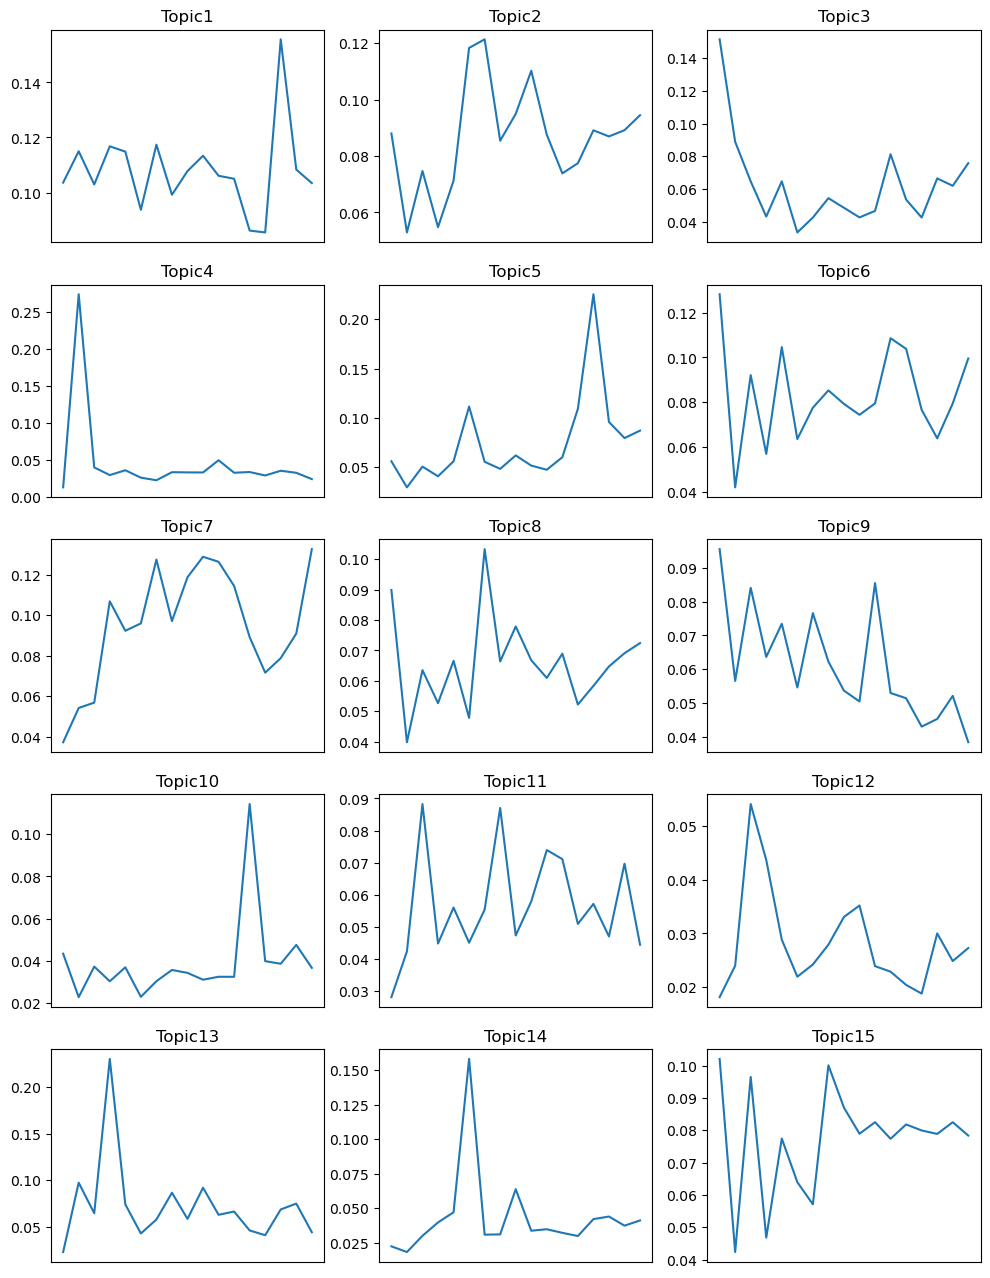

In [21]:
# topic3,4,9,13은 초기에 비중이 높았다가 뒤로 가면서 점차 줄어드는 경향이 있다. 이를 Cold Topic이라 부른다.
# 반면 topic5,10은 뒤로 가면서 비중이 더 높아지는 경향이 있는데 이런 유형을 Hot Topic이라 부른다.

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(5, 3, sharex='col', figsize=(12,16))
for col, ax in zip(trend.columns.tolist(), axes.ravel()):
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)
    ax.plot(trend[col])
plt.show()    

In [22]:
# 동적 토픽 모델링
# 최대한 이전 토픽을 반영하여 다음 시간의 토픽을 추출하는 것
import pandas as pd

df=pd.read_csv('petition_sampled.csv')
df_sorted = df.sort_values(by='start') # 문서를 시작날짜 순으로 정렬

#time slice를 생성, 월별로 변화를 보기 위해 연도와 월만 추출하여 time 열 생성
df_sorted['time'] = df_sorted['start'].map(lambda x : x[:7])

# 월별로 문서가 몇건인지를 계산하여 time_slice에 저장
time_slice = list(df_sorted['time'].value_counts().sort_index())
print(time_slice, sum(time_slice))

[83, 906, 298, 1446, 926, 1514, 1304, 1097, 1217, 1301, 1246, 1291, 1390, 1155, 1277, 1187, 439] 18077


In [23]:
# 시간 구간을 리스트로 작성
time_tag = sorted(list(set(df_sorted['time'])))
print(time_tag)

['2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12']


In [24]:
from gensim.corpora.dictionary import Dictionary
from konlpy.tag import Okt # konlpy에서 Twitter 형태소 분석기를 import
twit = Okt()

def tokenizer(doc): # 명사만 사용
    return [token for token in twit.nouns(doc) if len(token) > 1]

# 청원 데이터의 텍스트를 토큰화
texts = [tokenizer(news) for news in df_sorted['content']]

# 토큰화 결과로부터 딕셔너리 생성
dictionary = Dictionary(texts)
print('#Number of initial unique words in documents:', len(dictionary))

# 문서 빈도수가 너무 적거나 높은 단어를 필터링하고 특성을 단어의 빈도순으로 선택
dictionary.filter_extremes(keep_n = 2000, no_below=5, no_above=0.5)
print('#Number of unique words after removing rare and common words:', len(dictionary))

# 카운트 벡터로 변환
corpus = [dictionary.doc2bow(text) for text in texts]
print('#Number of unique tokens: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

#Number of initial unique words in documents: 36344
#Number of unique words after removing rare and common words: 2000
#Number of unique tokens: 2000
#Number of documents: 18077


-1.7493528544065975
num_topics:6, perplexity:-6.903, coherence:-2.204
num_topics:7, perplexity:-6.885, coherence:-2.174
num_topics:8, perplexity:-6.886, coherence:-2.181
num_topics:9, perplexity:-6.875, coherence:-2.323
num_topics:10, perplexity:-6.860, coherence:-2.298
num_topics:11, perplexity:-6.863, coherence:-2.355
num_topics:12, perplexity:-6.864, coherence:-2.616
num_topics:13, perplexity:-6.872, coherence:-2.333
num_topics:14, perplexity:-6.884, coherence:-2.439
num_topics:15, perplexity:-6.946, coherence:-2.452


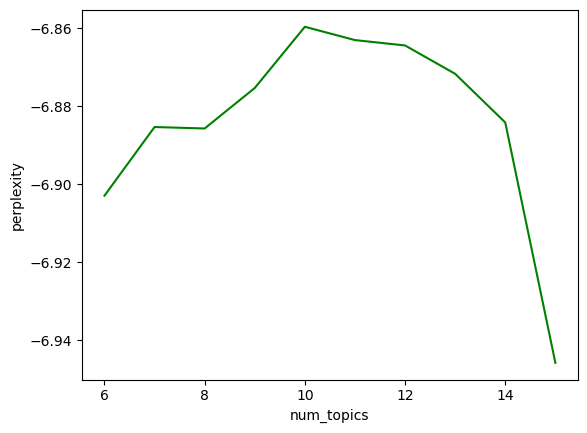

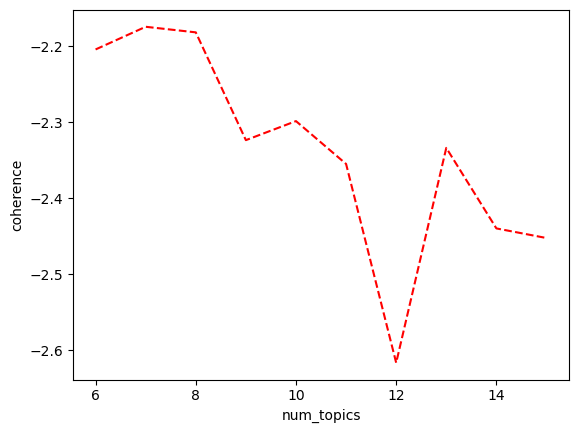

In [25]:
# 적절한 토픽 수를 알아보기 위해 토픽 수를 바꿔가면서 log_perplexity와 coherence를 계산

# 토픽 수가 6,7,8 일때 응집도가 높고, 혼란도는 7,8보다 6이 더 낮은 것을 볼 수있다. 따라서 토픽의 수는 6 
from gensim.models import CoherenceModel

coherence = cm.get_coherence()
print(coherence)
show_coherence(corpus, dictionary, start=6, end=15)

In [26]:
# LdaSeqModel을 실행
from gensim.models import LdaSeqModel
import warnings
warnings.filterwarnings('ignore')

# 시간이 많이 소요됨
ldaseq = LdaSeqModel(corpus = corpus, id2word = dictionary, time_slice = time_slice, num_topics=6, random_state=7)

In [27]:
# 토픽 결과로부터 상위 n개의 단어만 반환하는 함수 작성
def get_topic_words(topic, top_n_words=10):
    words, _ = zip(*topic)
    return words[:top_n_words]

# 주어진 토픽에 대해 시간별로 상위단어를 간략하게 출력하는 함수 작성
def print_topic_times(model, topic, time_tag, top_n_words=10):
    topic_times = model.print_topic_times(topic)
    for i in range(len(topic_times)):
        print(time_tag[i]+':', get_topic_words(topic_times[i], top_n_words))

In [28]:
# 4번 토픽에 대해 시간별로 상위 8개의 단어를 출력
print_topic_times(ldaseq, 4, time_tag, 8)

2017-08: ('청소년', '보호', '경찰', '생각', '범죄', '폐지', '사건', '피해자')
2017-09: ('청소년', '보호', '생각', '범죄', '경찰', '폐지', '사건', '피해자')
2017-10: ('경찰', '범죄', '국민', '대한민국', '사람', '위해', '피해자', '청소년')
2017-11: ('경찰', '범죄', '국민', '사람', '대한민국', '위해', '사건', '생각')
2017-12: ('사람', '경찰', '범죄', '생각', '처벌', '대한민국', '국민', '피해자')
2018-01: ('사람', '선수', '처벌', '생각', '피해자', '여성', '범죄', '경찰')
2018-02: ('사람', '선수', '처벌', '생각', '여성', '피해자', '사회', '범죄')
2018-03: ('사람', '처벌', '여성', '생각', '피해자', '사회', '선수', '범죄')
2018-04: ('사람', '처벌', '생각', '여성', '피해자', '사회', '범죄', '사건')
2018-05: ('사람', '처벌', '생각', '여성', '피해자', '사건', '범죄', '사회')
2018-06: ('사람', '처벌', '생각', '여성', '피해자', '사회', '사건', '범죄')
2018-07: ('사람', '처벌', '생각', '여성', '피해자', '사건', '사회', '남성')
2018-08: ('사람', '생각', '처벌', '여성', '피해자', '사건', '남성', '사회')
2018-09: ('사람', '생각', '처벌', '여성', '사건', '피해자', '사회', '남성')
2018-10: ('사람', '처벌', '생각', '사건', '피해자', '여성', '사회', '범죄')
2018-11: ('사람', '처벌', '생각', '사건', '피해자', '여성', '사회', '범죄')
2018-12: ('사람', '처벌', '생각', '사건', '여성', '피해자', '

In [29]:
# 구간별로 문서 토픽 분포의 평균을 구해 토픽의 트렌드로 사용
def get_topic_trends(model, corpus, time_slice):
    dtm = model.dtm_vis(0, corpus) # dtm_vis 매서드를 이용해 문서별 토픽 분포를 가져옴
    result = []
    start=0
    for index in time_slice: # 각 구간별 문서들에 대해 토픽분포의 평균을 구함
        result.append(np.array(dtm[0][start:start+index]).mean(axis=0))
        start += index
    return np.array(result)
topic_trends = get_topic_trends(ldaseq, corpus, time_slice)

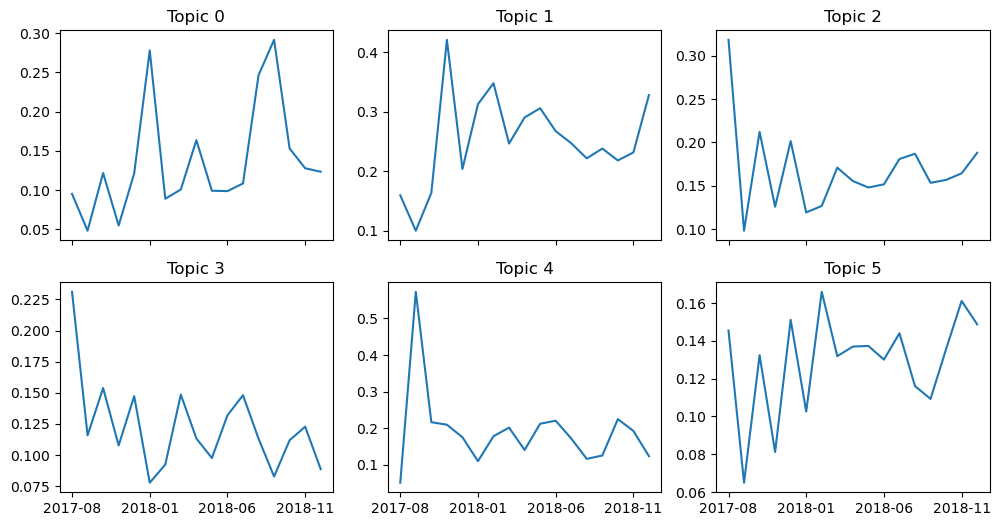

In [30]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

topic_titles = ['Topic '+str(i) for i in range(6)] #토픽 타이틀 생성
fig, axes = plt.subplots(2, 3, sharex='col', figsize=(12,6))
for i, (title,ax) in enumerate(zip(topic_titles, axes.ravel())):
    ax.set_title(title)
    ax.set_xticks([0,5,10,15])
    ax.set_xticklabels(time_tag[::5])
    ax.plot(topic_trends[:,i])
plt.savefig('dtm.png')
plt.show()

In [32]:
import pyLDAvis
pyLDAvis.enable_notebook()

# 특정 time slice의 토픽분포를 시각화 - ldaseq.dtm_vis() 매서드를 이용
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=0, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists = topic_term, doc_topic_dists = doc_topic, doc_lengths=doc_lengths, vocab= vocab, term_frequency = term_frequency)
pyLDAvis.display(vis_dtm) # 결과를 출력
# pyLDAvis.save_html(vis_dtm, 'lda_time0.html') # 결과를 별도의 html 파일로 저장